In [1]:
from torch.utils.data import DataLoader
from utils import *
from matplotlib import pyplot
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
print(device)

cuda


In [3]:
torch.set_default_dtype(torch.float64)
# Okay, we kind of have a way of loading the data
# We need to collect the data and feed it to the transformer model
# Now how do we that ?


# Torch Tensor data !
path = './Datasets/intracardiac_dataset/'
VmTrainData, pECGTrainData, VmDataTest, pECGTestData  = fileReader(path, 3200)
print('Data loading from files - complete')

VmTrainData = (VmTrainData - torch.min(VmTrainData))/(torch.max(VmTrainData) - torch.min(VmTrainData))
pECGTrainData = (pECGTrainData - torch.min(pECGTrainData))/(torch.max(pECGTrainData) - torch.min(pECGTrainData))

VmDataTest = (VmDataTest - torch.min(VmDataTest))/(torch.max(VmDataTest) - torch.min(VmDataTest))

pECGTestData = (pECGTestData - torch.min(pECGTestData))/(torch.max(pECGTestData) - torch.min(pECGTestData))
print('Normalization - complete!')


Loading datafiles : 100%|██████████| 3200/3200 [00:01<00:00, 2289.76it/s]


Data loading from files - complete
Normalization - complete!


In [4]:
## Model parameters
dim_val = 512
n_heads = 2
n_decoder_layers = 2
n_encoder_layers = 2
input_size = 12
dec_seq_len = 10 
enc_seq_len = 2
output_sequence_length = 2
max_seq_len = enc_seq_len
train_batch_size = 32
test_batch_size = 10
batch_first= False
output_size = 75

In [5]:
from dataset import TransformerDataset
# Get the indices of the sequences
# The idea is: start - stop, where stop - start is window_size
# This means, each tuple in VmInd and pECGInd is 50 steps
datInd = get_indices_entire_sequence(VmData = VmTrainData, 
                                            ECGData = pECGTrainData, 
                                            window_size= enc_seq_len + output_sequence_length, 
                                            step_size = 1)

# Now let's collect the training data in the Transformer Dataset class
TrainData = TransformerDataset(VmData = VmTrainData,
                                    datInd=datInd,
                                    ECGData = pECGTrainData,
                                    enc_seq_len = enc_seq_len,
                                    dec_seq_len = dec_seq_len,
                                    target_seq_len = output_sequence_length
                                )


TrainData = DataLoader(TrainData, train_batch_size)

datInd = get_indices_entire_sequence(VmData = VmDataTest, 
                                            ECGData = pECGTestData, 
                                            window_size= enc_seq_len + output_sequence_length, 
                                            step_size = 1)


# Now, let's load the test data
TestData = TransformerDataset(VmData = VmDataTest, 
                                    ECGData = pECGTestData,
                                    datInd=datInd,
                                    enc_seq_len = enc_seq_len,
                                    dec_seq_len = dec_seq_len,
                                    target_seq_len = output_sequence_length
                                )

TestData = DataLoader(TestData, test_batch_size)


In [6]:
from models import TimeSeriesTransformer
model = TimeSeriesTransformer(
    dim_val=dim_val,
    batch_first=batch_first,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads,
    num_predicted_features=output_size
)

# Define the MSE loss
criterion = torch.nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)




In [7]:
EPOCHS = 20
for epoch in tqdm(range(EPOCHS), desc = 'Training ', unit='epochs'):
    batch = 0
    for src, trg, trg_y in tqdm(TrainData, unit = 'batches'):
        optimizer.zero_grad()
        
        # Do it for each step in the sequence and predict the loss
        seqLen = src.shape[2]
        loss = 0
        predList = []
        for i in range(seqLen):

            srciSeq = src[:, :, i, :]
            trgiSeq = trg[:, :, i, :]
            trg_yiSeq = trg_y[:, :, i, :]
            src_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=enc_seq_len
            )
            tgt_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=output_sequence_length
            )
            srciSeq = srciSeq.permute(1, 0, 2).to(device)
            trgiSeq = trgiSeq.permute(1, 0, 2).to(device)
            prediction = model(
                src=srciSeq,
                tgt=trgiSeq,
                src_mask=src_mask,
                tgt_mask=tgt_mask
            )
            
            predList.append(prediction.permute(1,0,2))
        
        loss = criterion(trg_y.to(device), torch.stack(predList, axis = 2).to(device))
        print("Epoch: {epoch}    sequence: {i}/{seqLen}    Loss: {loss}    batch: {batch}/{total_batches}".format(epoch=epoch+1, i=i+1, seqLen=seqLen, loss=loss.item(),batch=batch+1, total_batches=len(TrainData)))
        loss.backward()
        optimizer.step()

        batch+=1

    

Training :   0%|          | 0/20 [00:00<?, ?epochs/s]

Epoch: 1    sequence: 496/496    Loss: 0.48691857312510023    batch: 1/16


Epoch: 1    sequence: 496/496    Loss: 0.29648957121804237    batch: 2/16


Epoch: 1    sequence: 496/496    Loss: 0.20548555253255213    batch: 3/16


Epoch: 1    sequence: 496/496    Loss: 0.1605360371771046    batch: 4/16


Epoch: 1    sequence: 496/496    Loss: 0.1385331399048084    batch: 5/16


Epoch: 1    sequence: 496/496    Loss: 0.13238001783438305    batch: 6/16


Epoch: 1    sequence: 496/496    Loss: 0.12528069778101963    batch: 7/16


Epoch: 1    sequence: 496/496    Loss: 0.11815371384403842    batch: 8/16


Epoch: 1    sequence: 496/496    Loss: 0.11087214372469885    batch: 9/16


Epoch: 1    sequence: 496/496    Loss: 0.1066121234894558    batch: 10/16


Epoch: 1    sequence: 496/496    Loss: 0.11168173734341845    batch: 11/16


Epoch: 1    sequence: 496/496    Loss: 0.10389310883707356    batch: 12/16


Epoch: 1    sequence: 496/496    Loss: 0.10361888414924961    batch: 13/16


Epoch: 1    sequence: 496/496    Loss: 0.09375904869007867    batch: 14/16


Epoch: 1    sequence: 496/496    Loss: 0.09364161296935498    batch: 15/16


Epoch: 1    sequence: 496/496    Loss: 0.09032835028619901    batch: 16/16


Training :   5%|▌         | 1/20 [02:15<42:49, 135.24s/epochs]

Epoch: 2    sequence: 496/496    Loss: 0.07943549479517585    batch: 1/16


Epoch: 2    sequence: 496/496    Loss: 0.08290142489143047    batch: 2/16


Epoch: 2    sequence: 496/496    Loss: 0.07758019874588169    batch: 3/16


Epoch: 2    sequence: 496/496    Loss: 0.07146891371923146    batch: 4/16


Epoch: 2    sequence: 496/496    Loss: 0.06494346431351701    batch: 5/16


Epoch: 2    sequence: 496/496    Loss: 0.06568544459126911    batch: 6/16


Epoch: 2    sequence: 496/496    Loss: 0.06144251619072461    batch: 7/16


Epoch: 2    sequence: 496/496    Loss: 0.05796129188244043    batch: 8/16


Epoch: 2    sequence: 496/496    Loss: 0.05482831921215588    batch: 9/16


Epoch: 2    sequence: 496/496    Loss: 0.05471693055347759    batch: 10/16


Epoch: 2    sequence: 496/496    Loss: 0.06595714793304724    batch: 11/16


Epoch: 2    sequence: 496/496    Loss: 0.058948089603669256    batch: 12/16


Epoch: 2    sequence: 496/496    Loss: 0.061652780647338846    batch: 13/16


Epoch: 2    sequence: 496/496    Loss: 0.05379837526130967    batch: 14/16


Epoch: 2    sequence: 496/496    Loss: 0.0569197167380485    batch: 15/16


Epoch: 2    sequence: 496/496    Loss: 0.057321706830167254    batch: 16/16


Training :  10%|█         | 2/20 [04:30<40:36, 135.36s/epochs]

Epoch: 3    sequence: 496/496    Loss: 0.048761276766402746    batch: 1/16


Epoch: 3    sequence: 496/496    Loss: 0.05532490995605747    batch: 2/16


Epoch: 3    sequence: 496/496    Loss: 0.05188968685635783    batch: 3/16


Epoch: 3    sequence: 496/496    Loss: 0.048033056654010906    batch: 4/16


Epoch: 3    sequence: 496/496    Loss: 0.043428391399409995    batch: 5/16


Epoch: 3    sequence: 496/496    Loss: 0.04548389309467719    batch: 6/16


Epoch: 3    sequence: 496/496    Loss: 0.042779147768055054    batch: 7/16


Epoch: 3    sequence: 496/496    Loss: 0.04000618144161896    batch: 8/16


Epoch: 3    sequence: 496/496    Loss: 0.03743331741449777    batch: 9/16


Epoch: 3    sequence: 496/496    Loss: 0.03744636632596445    batch: 10/16


Epoch: 3    sequence: 496/496    Loss: 0.048223378479579034    batch: 11/16


Epoch: 3    sequence: 496/496    Loss: 0.042669147617586035    batch: 12/16


Epoch: 3    sequence: 496/496    Loss: 0.04665403691242485    batch: 13/16


Epoch: 3    sequence: 496/496    Loss: 0.04118859197408312    batch: 14/16


Epoch: 3    sequence: 496/496    Loss: 0.04492065418323617    batch: 15/16


Epoch: 3    sequence: 496/496    Loss: 0.04637400356136926    batch: 16/16


Training :  15%|█▌        | 3/20 [06:46<38:22, 135.45s/epochs]

Epoch: 4    sequence: 496/496    Loss: 0.03831587557048845    batch: 1/16


Epoch: 4    sequence: 496/496    Loss: 0.0449980198579353    batch: 2/16


Epoch: 4    sequence: 496/496    Loss: 0.04195974866205363    batch: 3/16


Epoch: 4    sequence: 496/496    Loss: 0.03870472291605195    batch: 4/16


Epoch: 4    sequence: 496/496    Loss: 0.03465022594626303    batch: 5/16


Epoch: 4    sequence: 496/496    Loss: 0.03698203351644972    batch: 6/16


Epoch: 4    sequence: 496/496    Loss: 0.03448989072246256    batch: 7/16


Epoch: 4    sequence: 496/496    Loss: 0.032506641826143635    batch: 8/16


Epoch: 4    sequence: 496/496    Loss: 0.030599233289454856    batch: 9/16


Epoch: 4    sequence: 496/496    Loss: 0.031029166801981187    batch: 10/16


Epoch: 4    sequence: 496/496    Loss: 0.04101651380607989    batch: 11/16


Epoch: 4    sequence: 496/496    Loss: 0.03619734921723685    batch: 12/16


Epoch: 4    sequence: 496/496    Loss: 0.0399041868894835    batch: 13/16


Epoch: 4    sequence: 496/496    Loss: 0.03496952348556055    batch: 14/16


Epoch: 4    sequence: 496/496    Loss: 0.0385056345833821    batch: 15/16


Epoch: 4    sequence: 496/496    Loss: 0.04007233051333949    batch: 16/16


Training :  20%|██        | 4/20 [09:01<36:07, 135.47s/epochs]

Epoch: 5    sequence: 496/496    Loss: 0.03283189722545361    batch: 1/16


Epoch: 5    sequence: 496/496    Loss: 0.0388571292589429    batch: 2/16


Epoch: 5    sequence: 496/496    Loss: 0.03615619466454649    batch: 3/16


Epoch: 5    sequence: 496/496    Loss: 0.03373001217804334    batch: 4/16


Epoch: 5    sequence: 496/496    Loss: 0.029927256693858956    batch: 5/16


Epoch: 5    sequence: 496/496    Loss: 0.03212586188111137    batch: 6/16


Epoch: 5    sequence: 496/496    Loss: 0.030141345082116973    batch: 7/16


Epoch: 5    sequence: 496/496    Loss: 0.028438419108622236    batch: 8/16


Epoch: 5    sequence: 496/496    Loss: 0.026820304296288996    batch: 9/16


Epoch: 5    sequence: 496/496    Loss: 0.02732096478725353    batch: 10/16


Epoch: 5    sequence: 496/496    Loss: 0.036673503575668856    batch: 11/16


Epoch: 5    sequence: 496/496    Loss: 0.032392072349225365    batch: 12/16


Epoch: 5    sequence: 496/496    Loss: 0.0352140751605447    batch: 13/16


Epoch: 5    sequence: 496/496    Loss: 0.030795200132447645    batch: 14/16


Epoch: 5    sequence: 496/496    Loss: 0.0340408915328152    batch: 15/16


Epoch: 5    sequence: 496/496    Loss: 0.035128045328115816    batch: 16/16


Training :  25%|██▌       | 5/20 [11:17<33:54, 135.64s/epochs]

Epoch: 6    sequence: 496/496    Loss: 0.02924135794961719    batch: 1/16


Epoch: 6    sequence: 496/496    Loss: 0.034246518242881455    batch: 2/16


Epoch: 6    sequence: 496/496    Loss: 0.03233742182088849    batch: 3/16


Epoch: 6    sequence: 496/496    Loss: 0.03045086660749202    batch: 4/16


Epoch: 6    sequence: 496/496    Loss: 0.026871480987137132    batch: 5/16


Epoch: 6    sequence: 496/496    Loss: 0.0287801491417134    batch: 6/16


Epoch: 6    sequence: 496/496    Loss: 0.027306405607974385    batch: 7/16


Epoch: 6    sequence: 496/496    Loss: 0.025865300596829788    batch: 8/16


Epoch: 6    sequence: 496/496    Loss: 0.024498668173861322    batch: 9/16


Epoch: 6    sequence: 496/496    Loss: 0.02495765489907456    batch: 10/16


Epoch: 6    sequence: 496/496    Loss: 0.03341294599582995    batch: 11/16


Epoch: 6    sequence: 496/496    Loss: 0.029882053625006306    batch: 12/16


Epoch: 6    sequence: 496/496    Loss: 0.031601606348178775    batch: 13/16


Epoch: 6    sequence: 496/496    Loss: 0.027809449120686343    batch: 14/16


Epoch: 6    sequence: 496/496    Loss: 0.030880227228744807    batch: 15/16


Epoch: 6    sequence: 496/496    Loss: 0.03140148971804543    batch: 16/16


Training :  30%|███       | 6/20 [13:33<31:40, 135.75s/epochs]

Epoch: 7    sequence: 496/496    Loss: 0.02663115885786842    batch: 1/16


Epoch: 7    sequence: 496/496    Loss: 0.03102418566401886    batch: 2/16


Epoch: 7    sequence: 496/496    Loss: 0.02958961218418373    batch: 3/16


Epoch: 7    sequence: 496/496    Loss: 0.028094127159452868    batch: 4/16


Epoch: 7    sequence: 496/496    Loss: 0.024665508801321883    batch: 5/16


Epoch: 7    sequence: 496/496    Loss: 0.02632929693465636    batch: 6/16


Epoch: 7    sequence: 496/496    Loss: 0.025183185328592782    batch: 7/16


Epoch: 7    sequence: 496/496    Loss: 0.02393650988696881    batch: 8/16


Epoch: 7    sequence: 496/496    Loss: 0.022778216817166446    batch: 9/16


Epoch: 7    sequence: 496/496    Loss: 0.02317359497311454    batch: 10/16


Epoch: 7    sequence: 496/496    Loss: 0.030850703038213256    batch: 11/16


Epoch: 7    sequence: 496/496    Loss: 0.027659444701749154    batch: 12/16


Epoch: 7    sequence: 496/496    Loss: 0.029094326560799407    batch: 13/16


Epoch: 7    sequence: 496/496    Loss: 0.025624595997730412    batch: 14/16


Epoch: 7    sequence: 496/496    Loss: 0.028608009711871295    batch: 15/16


Epoch: 7    sequence: 496/496    Loss: 0.028876072337838107    batch: 16/16


Training :  35%|███▌      | 7/20 [15:49<29:25, 135.80s/epochs]

Epoch: 8    sequence: 496/496    Loss: 0.024749831073315798    batch: 1/16


Epoch: 8    sequence: 496/496    Loss: 0.028636733216948602    batch: 2/16


Epoch: 8    sequence: 496/496    Loss: 0.02759463050328332    batch: 3/16


Epoch: 8    sequence: 496/496    Loss: 0.026224955520369846    batch: 4/16


Epoch: 8    sequence: 496/496    Loss: 0.023007486068765497    batch: 5/16


Epoch: 8    sequence: 496/496    Loss: 0.02447450756660284    batch: 6/16


Epoch: 8    sequence: 496/496    Loss: 0.023432406722872837    batch: 7/16


Epoch: 8    sequence: 496/496    Loss: 0.022496256351467715    batch: 8/16


Epoch: 8    sequence: 496/496    Loss: 0.02134919834284136    batch: 9/16


Epoch: 8    sequence: 496/496    Loss: 0.021660320942787456    batch: 10/16


Epoch: 8    sequence: 496/496    Loss: 0.028830670183814695    batch: 11/16


Epoch: 8    sequence: 496/496    Loss: 0.02591700788246947    batch: 12/16


Epoch: 8    sequence: 496/496    Loss: 0.02714612539709219    batch: 13/16


Epoch: 8    sequence: 496/496    Loss: 0.023855195652855342    batch: 14/16


Epoch: 8    sequence: 496/496    Loss: 0.026679873384381287    batch: 15/16


Epoch: 8    sequence: 496/496    Loss: 0.026922029853938226    batch: 16/16


Training :  40%|████      | 8/20 [18:05<27:10, 135.87s/epochs]

Epoch: 9    sequence: 496/496    Loss: 0.023229739997731765    batch: 1/16


Epoch: 9    sequence: 496/496    Loss: 0.026764095356118227    batch: 2/16


Epoch: 9    sequence: 496/496    Loss: 0.02594623272830773    batch: 3/16


Epoch: 9    sequence: 496/496    Loss: 0.02466175157183169    batch: 4/16


Epoch: 9    sequence: 496/496    Loss: 0.021628203112749815    batch: 5/16


Epoch: 9    sequence: 496/496    Loss: 0.022909510587814427    batch: 6/16


Epoch: 9    sequence: 496/496    Loss: 0.022134281997762364    batch: 7/16


Epoch: 9    sequence: 496/496    Loss: 0.021230807627880415    batch: 8/16


Epoch: 9    sequence: 496/496    Loss: 0.020150256524262035    batch: 9/16


Epoch: 9    sequence: 496/496    Loss: 0.020305896505650456    batch: 10/16


Epoch: 9    sequence: 496/496    Loss: 0.02703498228026963    batch: 11/16


Epoch: 9    sequence: 496/496    Loss: 0.024394131140635315    batch: 12/16


Epoch: 9    sequence: 496/496    Loss: 0.02537143492882333    batch: 13/16


Epoch: 9    sequence: 496/496    Loss: 0.022472948864992275    batch: 14/16


Epoch: 9    sequence: 496/496    Loss: 0.02514486235062792    batch: 15/16


Epoch: 9    sequence: 496/496    Loss: 0.02529132089180772    batch: 16/16


Training :  45%|████▌     | 9/20 [20:21<24:55, 135.95s/epochs]

Epoch: 10    sequence: 496/496    Loss: 0.021831177967446044    batch: 1/16


Epoch: 10    sequence: 496/496    Loss: 0.02514974226298425    batch: 2/16


Epoch: 10    sequence: 496/496    Loss: 0.024464108645210595    batch: 3/16


Epoch: 10    sequence: 496/496    Loss: 0.02329966862049497    batch: 4/16


Epoch: 10    sequence: 496/496    Loss: 0.020458475695780014    batch: 5/16


Epoch: 10    sequence: 496/496    Loss: 0.021651992614589683    batch: 6/16


Epoch: 10    sequence: 496/496    Loss: 0.020942121034193652    batch: 7/16


Epoch: 10    sequence: 496/496    Loss: 0.020103338328625004    batch: 8/16


Epoch: 10    sequence: 496/496    Loss: 0.01900658562081352    batch: 9/16


Epoch: 10    sequence: 496/496    Loss: 0.01932977011034056    batch: 10/16


Epoch: 10    sequence: 496/496    Loss: 0.02537758199842662    batch: 11/16


Epoch: 10    sequence: 496/496    Loss: 0.022871767002105824    batch: 12/16


Epoch: 10    sequence: 496/496    Loss: 0.023922474091310344    batch: 13/16


Epoch: 10    sequence: 496/496    Loss: 0.021230198669574055    batch: 14/16


Epoch: 10    sequence: 496/496    Loss: 0.023768778610013818    batch: 15/16


Epoch: 10    sequence: 496/496    Loss: 0.02374070513895384    batch: 16/16


Training :  50%|█████     | 10/20 [22:37<22:39, 135.94s/epochs]

Epoch: 11    sequence: 496/496    Loss: 0.020565687244522103    batch: 1/16


Epoch: 11    sequence: 496/496    Loss: 0.023778230164337655    batch: 2/16


Epoch: 11    sequence: 496/496    Loss: 0.023117828749746126    batch: 3/16


Epoch: 11    sequence: 496/496    Loss: 0.021952130122487843    batch: 4/16


Epoch: 11    sequence: 496/496    Loss: 0.019318246504798783    batch: 5/16


Epoch: 11    sequence: 496/496    Loss: 0.020538429668705716    batch: 6/16


Epoch: 11    sequence: 496/496    Loss: 0.019815378103641743    batch: 7/16


Epoch: 11    sequence: 496/496    Loss: 0.019048260218355328    batch: 8/16


Epoch: 11    sequence: 496/496    Loss: 0.018108905150010287    batch: 9/16


Epoch: 11    sequence: 496/496    Loss: 0.018292771228101586    batch: 10/16


Epoch: 11    sequence: 496/496    Loss: 0.023848574548997747    batch: 11/16


Epoch: 11    sequence: 496/496    Loss: 0.021506830229030518    batch: 12/16


Epoch: 11    sequence: 496/496    Loss: 0.022562202995132685    batch: 13/16


Epoch: 11    sequence: 496/496    Loss: 0.02009844628636511    batch: 14/16


Epoch: 11    sequence: 496/496    Loss: 0.02246944290999683    batch: 15/16


Epoch: 11    sequence: 496/496    Loss: 0.022274630871947743    batch: 16/16


Training :  55%|█████▌    | 11/20 [24:53<20:23, 135.91s/epochs]

Epoch: 12    sequence: 496/496    Loss: 0.019514982532140523    batch: 1/16


Epoch: 12    sequence: 496/496    Loss: 0.02241299976999368    batch: 2/16


Epoch: 12    sequence: 496/496    Loss: 0.0218704280212711    batch: 3/16


Epoch: 12    sequence: 496/496    Loss: 0.020833250003150415    batch: 4/16


Epoch: 12    sequence: 496/496    Loss: 0.018378965646178226    batch: 5/16


Epoch: 12    sequence: 496/496    Loss: 0.019436543793586402    batch: 6/16


Epoch: 12    sequence: 496/496    Loss: 0.018856338397511205    batch: 7/16


Epoch: 12    sequence: 496/496    Loss: 0.018204911892927153    batch: 8/16


Epoch: 12    sequence: 496/496    Loss: 0.017257481756225164    batch: 9/16


Epoch: 12    sequence: 496/496    Loss: 0.017415094914191135    batch: 10/16


Epoch: 12    sequence: 496/496    Loss: 0.022473929141475998    batch: 11/16


Epoch: 12    sequence: 496/496    Loss: 0.020365691333558297    batch: 12/16


Epoch: 12    sequence: 496/496    Loss: 0.02136834982072271    batch: 13/16


Epoch: 12    sequence: 496/496    Loss: 0.01905147520725973    batch: 14/16


Epoch: 12    sequence: 496/496    Loss: 0.0213433312933306    batch: 15/16


Epoch: 12    sequence: 496/496    Loss: 0.0211246147732144    batch: 16/16


Training :  60%|██████    | 12/20 [27:09<18:07, 135.91s/epochs]

Epoch: 13    sequence: 496/496    Loss: 0.018578901918429824    batch: 1/16


Epoch: 13    sequence: 496/496    Loss: 0.02125360047323097    batch: 2/16


Epoch: 13    sequence: 496/496    Loss: 0.020714596850144134    batch: 3/16


Epoch: 13    sequence: 496/496    Loss: 0.019802485744587508    batch: 4/16


Epoch: 13    sequence: 496/496    Loss: 0.017486680668160226    batch: 5/16


Epoch: 13    sequence: 496/496    Loss: 0.01843324552089134    batch: 6/16


Epoch: 13    sequence: 496/496    Loss: 0.01789578000021863    batch: 7/16


Epoch: 13    sequence: 496/496    Loss: 0.01734140238194197    batch: 8/16


Epoch: 13    sequence: 496/496    Loss: 0.01652367861692752    batch: 9/16


Epoch: 13    sequence: 496/496    Loss: 0.01656876745733549    batch: 10/16


Epoch: 13    sequence: 496/496    Loss: 0.021233563213534017    batch: 11/16


Epoch: 13    sequence: 496/496    Loss: 0.01934877816087215    batch: 12/16


Epoch: 13    sequence: 496/496    Loss: 0.020215481841762587    batch: 13/16


Epoch: 13    sequence: 496/496    Loss: 0.018062099852746916    batch: 14/16


Epoch: 13    sequence: 496/496    Loss: 0.020184388496846443    batch: 15/16


Epoch: 13    sequence: 496/496    Loss: 0.01993319776311279    batch: 16/16


Training :  65%|██████▌   | 13/20 [29:25<15:51, 135.98s/epochs]

Epoch: 14    sequence: 496/496    Loss: 0.01767397842515155    batch: 1/16


Epoch: 14    sequence: 496/496    Loss: 0.020151630383234385    batch: 2/16


Epoch: 14    sequence: 496/496    Loss: 0.01965823307812814    batch: 3/16


Epoch: 14    sequence: 496/496    Loss: 0.01878669863316089    batch: 4/16


Epoch: 14    sequence: 496/496    Loss: 0.016685681487740592    batch: 5/16


Epoch: 14    sequence: 496/496    Loss: 0.017618535940418626    batch: 6/16


Epoch: 14    sequence: 496/496    Loss: 0.017080112625883413    batch: 7/16


Epoch: 14    sequence: 496/496    Loss: 0.016505246345264728    batch: 8/16


Epoch: 14    sequence: 496/496    Loss: 0.015774714984250468    batch: 9/16


Epoch: 14    sequence: 496/496    Loss: 0.015812419159353403    batch: 10/16


Epoch: 14    sequence: 496/496    Loss: 0.020074258874769196    batch: 11/16


Epoch: 14    sequence: 496/496    Loss: 0.01839996294462904    batch: 12/16


Epoch: 14    sequence: 496/496    Loss: 0.019140087033090704    batch: 13/16


Epoch: 14    sequence: 496/496    Loss: 0.01723075150821448    batch: 14/16


Epoch: 14    sequence: 496/496    Loss: 0.019182102921055287    batch: 15/16


Epoch: 14    sequence: 496/496    Loss: 0.01892041913021815    batch: 16/16


Training :  70%|███████   | 14/20 [31:47<13:47, 137.91s/epochs]

Epoch: 15    sequence: 496/496    Loss: 0.016840974589925842    batch: 1/16


Epoch: 15    sequence: 496/496    Loss: 0.019120593936746602    batch: 2/16


Epoch: 15    sequence: 496/496    Loss: 0.018695345160264006    batch: 3/16


Epoch: 15    sequence: 496/496    Loss: 0.01794188154386431    batch: 4/16


Epoch: 15    sequence: 496/496    Loss: 0.01589969072177404    batch: 5/16


Epoch: 15    sequence: 496/496    Loss: 0.01673669453577795    batch: 6/16


Epoch: 15    sequence: 496/496    Loss: 0.01633680127098112    batch: 7/16


Epoch: 15    sequence: 496/496    Loss: 0.015790359965325886    batch: 8/16


Epoch: 15    sequence: 496/496    Loss: 0.015115026429220163    batch: 9/16


Epoch: 15    sequence: 496/496    Loss: 0.015123621725641434    batch: 10/16


Epoch: 15    sequence: 496/496    Loss: 0.019011867572911397    batch: 11/16


Epoch: 15    sequence: 496/496    Loss: 0.017445502984779763    batch: 12/16


Epoch: 15    sequence: 496/496    Loss: 0.018174359091801803    batch: 13/16


Epoch: 15    sequence: 496/496    Loss: 0.016376106451726446    batch: 14/16


Epoch: 15    sequence: 496/496    Loss: 0.0182989183176792    batch: 15/16


Epoch: 15    sequence: 496/496    Loss: 0.017941835652165027    batch: 16/16


Training :  75%|███████▌  | 15/20 [34:10<11:36, 139.24s/epochs]

Epoch: 16    sequence: 496/496    Loss: 0.016078671176044973    batch: 1/16


Epoch: 16    sequence: 496/496    Loss: 0.018112383172207907    batch: 2/16


Epoch: 16    sequence: 496/496    Loss: 0.017836158105739675    batch: 3/16


Epoch: 16    sequence: 496/496    Loss: 0.017081527501593047    batch: 4/16


Epoch: 16    sequence: 496/496    Loss: 0.015156773705673936    batch: 5/16


Epoch: 16    sequence: 496/496    Loss: 0.015996713346745305    batch: 6/16


Epoch: 16    sequence: 496/496    Loss: 0.015617426701168497    batch: 7/16


Epoch: 16    sequence: 496/496    Loss: 0.015086509920518427    batch: 8/16


Epoch: 16    sequence: 496/496    Loss: 0.01442876097530794    batch: 9/16


Epoch: 16    sequence: 496/496    Loss: 0.0144679840648397    batch: 10/16


Epoch: 16    sequence: 496/496    Loss: 0.01814644788701321    batch: 11/16


Epoch: 16    sequence: 496/496    Loss: 0.0166435637021763    batch: 12/16


Epoch: 16    sequence: 496/496    Loss: 0.017274879410245983    batch: 13/16


Epoch: 16    sequence: 496/496    Loss: 0.0156791153858313    batch: 14/16


Epoch: 16    sequence: 496/496    Loss: 0.017389541458268484    batch: 15/16


Epoch: 16    sequence: 496/496    Loss: 0.01704528654207558    batch: 16/16


Training :  80%|████████  | 16/20 [36:32<09:20, 140.16s/epochs]

Epoch: 17    sequence: 496/496    Loss: 0.015315567725235263    batch: 1/16


Epoch: 17    sequence: 496/496    Loss: 0.0172449645455025    batch: 2/16


Epoch: 17    sequence: 496/496    Loss: 0.016959666387667358    batch: 3/16


Epoch: 17    sequence: 496/496    Loss: 0.016289294099059975    batch: 4/16


Epoch: 17    sequence: 496/496    Loss: 0.014509742640069207    batch: 5/16


Epoch: 17    sequence: 496/496    Loss: 0.015270522249382825    batch: 6/16


Epoch: 17    sequence: 496/496    Loss: 0.014914542631763445    batch: 7/16


Epoch: 17    sequence: 496/496    Loss: 0.014475728289816104    batch: 8/16


Epoch: 17    sequence: 496/496    Loss: 0.013825457394706572    batch: 9/16


Epoch: 17    sequence: 496/496    Loss: 0.013810748706171529    batch: 10/16


Epoch: 17    sequence: 496/496    Loss: 0.01728908208619251    batch: 11/16


Epoch: 17    sequence: 496/496    Loss: 0.01591578995742272    batch: 12/16


Epoch: 17    sequence: 496/496    Loss: 0.016466831859641633    batch: 13/16


Epoch: 17    sequence: 496/496    Loss: 0.01495663811048021    batch: 14/16


Epoch: 17    sequence: 496/496    Loss: 0.016633238549423408    batch: 15/16


Epoch: 17    sequence: 496/496    Loss: 0.01632565278538194    batch: 16/16


Training :  85%|████████▌ | 17/20 [38:54<07:02, 140.83s/epochs]

Epoch: 18    sequence: 496/496    Loss: 0.014684026559022475    batch: 1/16


Epoch: 18    sequence: 496/496    Loss: 0.016387263870234228    batch: 2/16


Epoch: 18    sequence: 496/496    Loss: 0.01618610167319816    batch: 3/16


Epoch: 18    sequence: 496/496    Loss: 0.015568737644711355    batch: 4/16


Epoch: 18    sequence: 496/496    Loss: 0.013851622139925515    batch: 5/16


Epoch: 18    sequence: 496/496    Loss: 0.014634083849046358    batch: 6/16


Epoch: 18    sequence: 496/496    Loss: 0.01420389486635336    batch: 7/16


Epoch: 18    sequence: 496/496    Loss: 0.013888672999184606    batch: 8/16


Epoch: 18    sequence: 496/496    Loss: 0.01327910787448371    batch: 9/16


Epoch: 18    sequence: 496/496    Loss: 0.013241419918237017    batch: 10/16


Epoch: 18    sequence: 496/496    Loss: 0.01645801886770803    batch: 11/16


Epoch: 18    sequence: 496/496    Loss: 0.015195620517704796    batch: 12/16


Epoch: 18    sequence: 496/496    Loss: 0.01571556656890239    batch: 13/16


Epoch: 18    sequence: 496/496    Loss: 0.014293605487176682    batch: 14/16


Epoch: 18    sequence: 496/496    Loss: 0.0158332358379183    batch: 15/16


Epoch: 18    sequence: 496/496    Loss: 0.015552660666548219    batch: 16/16


Training :  90%|█████████ | 18/20 [41:17<04:42, 141.31s/epochs]

Epoch: 19    sequence: 496/496    Loss: 0.014016256839654781    batch: 1/16


Epoch: 19    sequence: 496/496    Loss: 0.015688395603576516    batch: 2/16


Epoch: 19    sequence: 496/496    Loss: 0.01546291607148052    batch: 3/16


Epoch: 19    sequence: 496/496    Loss: 0.014862325843918143    batch: 4/16


Epoch: 19    sequence: 496/496    Loss: 0.013305900258341876    batch: 5/16


Epoch: 19    sequence: 496/496    Loss: 0.014028159088151103    batch: 6/16


Epoch: 19    sequence: 496/496    Loss: 0.013608264067527107    batch: 7/16


Epoch: 19    sequence: 496/496    Loss: 0.013321179226459033    batch: 8/16


Epoch: 19    sequence: 496/496    Loss: 0.01272158608044848    batch: 9/16


Epoch: 19    sequence: 496/496    Loss: 0.012756005041962499    batch: 10/16


Epoch: 19    sequence: 496/496    Loss: 0.015732924092369673    batch: 11/16


Epoch: 19    sequence: 496/496    Loss: 0.014531008456664576    batch: 12/16


Epoch: 19    sequence: 496/496    Loss: 0.01501332109228777    batch: 13/16


Epoch: 19    sequence: 496/496    Loss: 0.013695392272219102    batch: 14/16


Epoch: 19    sequence: 496/496    Loss: 0.01512971270241368    batch: 15/16


Epoch: 19    sequence: 496/496    Loss: 0.014897644294170904    batch: 16/16


Training :  95%|█████████▌| 19/20 [43:39<02:21, 141.66s/epochs]

Epoch: 20    sequence: 496/496    Loss: 0.0134264446034305    batch: 1/16


Epoch: 20    sequence: 496/496    Loss: 0.014986142791811421    batch: 2/16


Epoch: 20    sequence: 496/496    Loss: 0.014821718783611966    batch: 3/16


Epoch: 20    sequence: 496/496    Loss: 0.014199859680105393    batch: 4/16


Epoch: 20    sequence: 496/496    Loss: 0.012743423431301113    batch: 5/16


Epoch: 20    sequence: 496/496    Loss: 0.01342801551405972    batch: 6/16


Epoch: 20    sequence: 496/496    Loss: 0.013037042930560346    batch: 7/16


Epoch: 20    sequence: 496/496    Loss: 0.012812609174815626    batch: 8/16


Epoch: 20    sequence: 496/496    Loss: 0.012198009471332911    batch: 9/16


Epoch: 20    sequence: 496/496    Loss: 0.012240334800167008    batch: 10/16


Epoch: 20    sequence: 496/496    Loss: 0.015028180821973023    batch: 11/16


Epoch: 20    sequence: 496/496    Loss: 0.013926293257987301    batch: 12/16


Epoch: 20    sequence: 496/496    Loss: 0.014443750020513253    batch: 13/16


Epoch: 20    sequence: 496/496    Loss: 0.013123268759947725    batch: 14/16


Epoch: 20    sequence: 496/496    Loss: 0.014480833167639835    batch: 15/16


Epoch: 20    sequence: 496/496    Loss: 0.014198941612506745    batch: 16/16


Training : 100%|██████████| 20/20 [46:02<00:00, 138.11s/epochs]


In [8]:
sequences = []
flag = True
sequences = None
with torch.no_grad():
    for src, trg, trg_y in tqdm(TestData, unit = 'batches'):
        optimizer.zero_grad()
        
        # Do it for each step in the sequence and predict the loss
        seqLen = src.shape[2]
        loss = 0
        predList = []
        for i in range(seqLen):

            srciSeq = src[:, :, i, :]
            trgiSeq = trg[:, :, i, :]
            trg_yiSeq = trg_y[:, :, i, :]
            src_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=enc_seq_len
            )
            tgt_mask = generate_square_subsequent_mask(
                dim1=output_sequence_length,
                dim2=output_sequence_length
            )
            srciSeq = srciSeq.permute(1, 0, 2)
            trgiSeq = trgiSeq.permute(1, 0, 2)
            prediction = model(
                src=srciSeq.to(device),
                tgt=trgiSeq.to(device),
                src_mask=src_mask,
                tgt_mask=tgt_mask
            )
            if flag:
                output = prediction.permute(1,0,2)[:, -1, :].unsqueeze(1)
                tru_output = trg_yiSeq[:,-1,:].unsqueeze(1)
                flag = False
            
            else:
                output = torch.cat((output, prediction.permute(1,0,2)[:, -1, :].unsqueeze(1)), axis = 1)
                tru_output = torch.cat([tru_output, trg_yiSeq[:,-1,:].unsqueeze(1)], axis = 1)
            
         
        if sequences is None:
            sequences = output
            tru_sequences = tru_output
        else:
            sequences = torch.cat([sequences, output], axis =0)
            tru_sequences = torch.cat([tru_sequences, tru_output], axis = 0)
        flag = True
    

100%|██████████| 50/50 [02:06<00:00,  2.52s/batches]


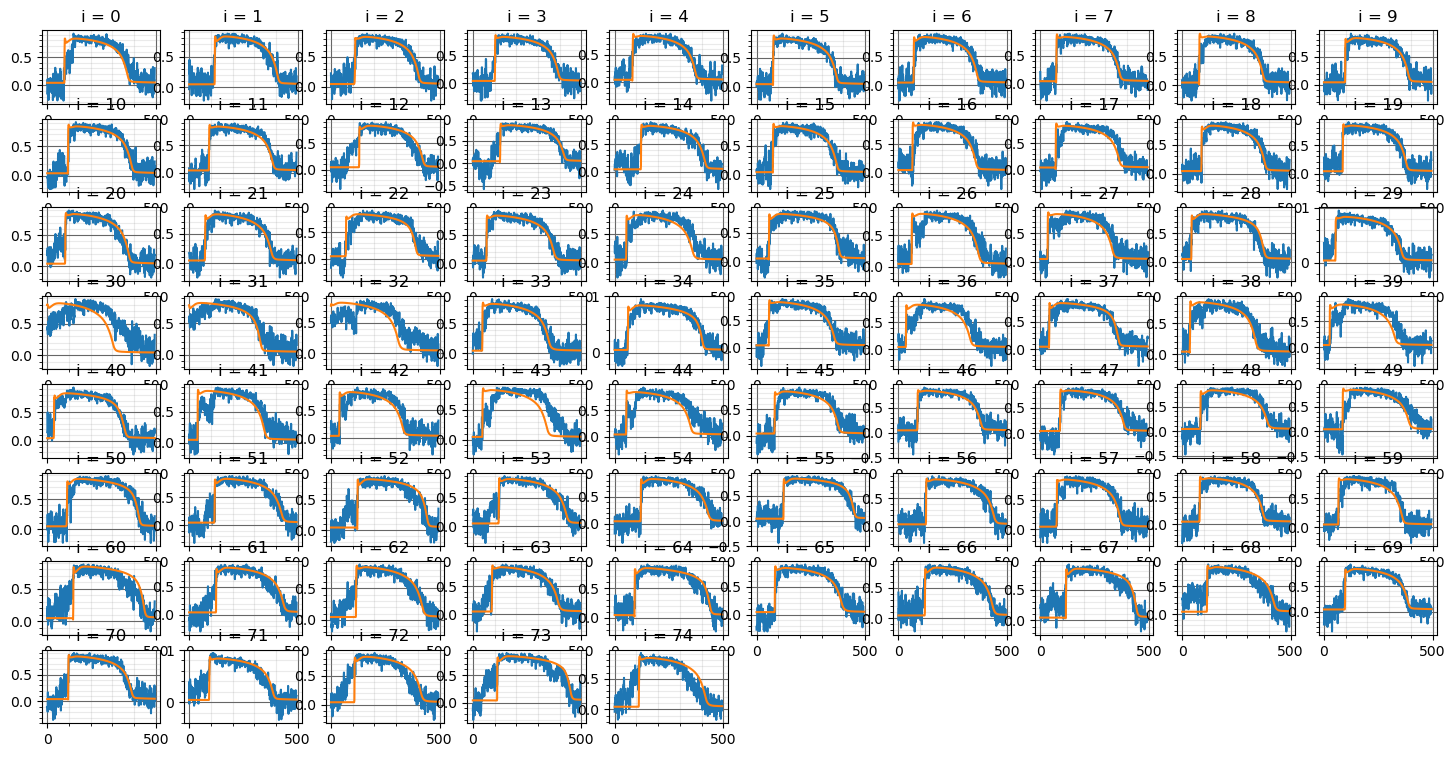

In [18]:
index = 0

pyplot.figure(figsize=(18, 9))

for count, i in enumerate(range(sequences.shape[2])):
    pyplot.subplot(8, 10, count + 1)
    pyplot.plot(sequences[index,:,i].cpu().numpy())
    pyplot.plot(tru_sequences[index,:,i].cpu().numpy())
    pyplot.title(f'i = {i}')
    pyplot.grid(visible=True, which='major', color='#666666', linestyle='-')
    pyplot.minorticks_on()
    pyplot.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# pyplot.plot(sequences[index,:,0].cpu().numpy())
# pyplot.plot(tru_sequences[index, :, 4])
pyplot.show()

In [10]:
print(sequences.shape)

torch.Size([497, 496, 75])
